In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

In [3]:
#Instantiate functions to compute activation and repression
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

In [3]:
def dual_control(x, t, n1, n2, theta1, theta2, k1, k2):
    x0, x1, e1, e2 = x
    dx0dt = Vin - lam*x0 - e0*nonlinearity(x0, kc, km) - e1*nonlinearity(x0, kc, km) 
    dx1dt = e1*nonlinearity(x0, kc, km) - e2*nonlinearity(x1, kc, km) - lam*x1
    de1dt = repression(x1, k1, theta1, n1) - lam*e1
    de2dt = activation(x1, k2, theta2, n2) - lam*e2
    return [dx0dt, dx1dt, de1dt, de2dt]  

In [4]:
def upstream_repression(x, t, n1, n2, theta1, theta2, k1, k2):
    x0, x1, e1, e2 = x
    dx0dt = Vin - lam*x0 - e0*nonlinearity(x0, kc, km) - e1*nonlinearity(x0, kc, km) 
    dx1dt = e1*nonlinearity(x0, kc, km) - e2*nonlinearity(x1, kc, km) - lam*x1
    de1dt = repression(x1, k1, theta1, n1) - lam*e1
    de2dt = k2 - lam*e2
    return [dx0dt, dx1dt, de1dt, de2dt]  

In [5]:
def downstream_activation(x, t, n1, n2, theta1, theta2, k1, k2):
    x0, x1, e1, e2 = x
    dx0dt = Vin - lam*x0 - e0*nonlinearity(x0, kc, km) - e1*nonlinearity(x0, kc, km) 
    dx1dt = e1*nonlinearity(x0, kc, km) - e2*nonlinearity(x1, kc, km) - lam*x1
    de1dt = k1 - lam*e1
    de2dt = activation(x1, k2, theta2, n2) - lam*e2
    return [dx0dt, dx1dt, de1dt, de2dt]  

In [4]:
#Times
t = np.linspace(0, 5e4, 101)
#Constants
Vin = 1
e0 = 0.0467 
lam = 1.93E-4 #1/s
#Assume equal kinetics for all three enzymes
kc = 12 #1/s
km = 10 
#Initial conditions
y0 = [2290.,0.,0.,0.] #[x0, x1, e1, e2]

Text(0, 0.5, 'Concentrations')

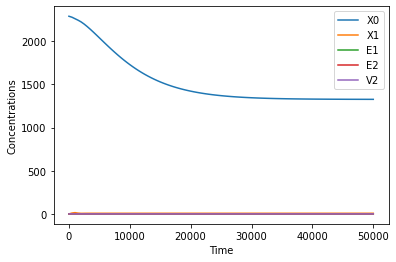

In [40]:
#Single solution code
n1 = 2
n2 = 2
theta1 = 5
theta2 = theta1
k1 = 0.00001
k2 = 0.00001
sol = odeint(dual_control, y0, t, args=(n1, n2, theta1, theta2, k1, k2))
v2 = sol[:, 3]*nonlinearity(sol[:, 1], kc, km)

plt.plot(t, sol[:, 0], label='X0')
plt.plot(t, sol[:, 1], label='X1')
plt.plot(t, sol[:, 2], label='E1')
plt.plot(t, sol[:, 3], label='E2')
plt.plot(t, v2, label='V2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')

In [5]:
n1 = 2
n2 = 2
num_points = 10
thetas = [0.01, 0.05, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 100]
ks = np.linspace(1E-7, 0.001, num_points)

In [14]:
#Solve grid of ODEs and save steady state values and final flux
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'v2']
ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            x0, x1, e1, e2 = odeint(dual_control, y0, t, args=(n1, n2, theta1, theta2, k1, k2))[-1, :]
            v2 = e2*nonlinearity(x1, kc, km)
            row = [theta1, k1, k2, x0, x1, e1, e2, v2]
            ss_data.loc[len(ss_data)] = row
ss_data.to_csv('dual_control.csv')

In [15]:
#Solve grid of ODEs and save steady state values and final flux
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'v2']
ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            x0, x1, e1, e2 = odeint(upstream_repression, y0, t, args=(n1, n2, theta1, theta2, k1, k2))[-1, :]
            v2 = e2*nonlinearity(x1, kc, km)
            row = [theta1, k1, k2, x0, x1, e1, e2, v2]
            ss_data.loc[len(ss_data)] = row
ss_data.to_csv('upstream_repression.csv')

In [17]:
#Solve grid of ODEs and save steady state values and final flux
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'v2']
ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            x0, x1, e1, e2 = odeint(downstream_activation, y0, t, args=(n1, n2, theta1, theta2, k1, k2))[-1, :]
            v2 = e2*nonlinearity(x1, kc, km)
            row = [theta1, k1, k2, x0, x1, e1, e2, v2]
            ss_data.loc[len(ss_data)] = row
ss_data.to_csv('downstream_activation.csv')

In [13]:
#Solve grid of ODEs and compute J1, J2
y0 = [2290.,0.,0.,0., 0., 0.] #[x0, x1, e1, e2]
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'j1', 'j2']
ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            x0, x1, e1, e2, j1, j2 = odeint(dual_control_j1j2, y0, t, args=(n1, n2, theta1, theta2, k1, k2))[-1, :]
            row = [theta1, k1, k2, x0, x1, e1, e2, j1, j2]
            ss_data.loc[len(ss_data)] = row
ss_data.to_csv('dual_control_j1j2.csv')

C:\Users\Charlotte\anaconda3\envs\thesis\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


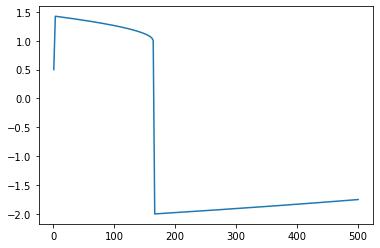

In [32]:
#Sample CVODE code with Van Der Pol Oscillator
import matplotlib.pyplot as plt
import numpy as np
from scikits.odes import ode

t0, y0 = 1, np.array([0.5, 0.5])  # initial condition
def van_der_pol(t, y, ydot):
    """ we create rhs equations for the problem"""
    ydot[0] = y[1]
    ydot[1] = 1000*(1.0-y[0]**2)*y[1]-y[0]

solution = ode('cvode', van_der_pol, old_api=False).solve(np.linspace(t0,500,200), y0)
plt.plot(solution.values.t, solution.values.y[:,0], label='Van der Pol oscillator')
plt.show()

In [33]:
#Single solution code using cvode
from scikits.odes.odeint import odeint
def dual_control_j1j2(t, y, ydot):
    x0, x1, e1, e2, j1, j2 = y

    dx0dt = Vin - lam*x0 - e0*nonlinearity(x0, kc, km) - e1*nonlinearity(x0, kc, km) 
    dx1dt = e1*nonlinearity(x0, kc, km) - e2*nonlinearity(x1, kc, km) - lam*x1
    de1dt = repression(x1, k1, theta1, n1) - lam*e1
    de2dt = activation(x1, k2, theta2, n2) - lam*e2
    v2 = e2*nonlinearity(x1, kc, km)
    j1 = (Vin - v2)**2
    j2 = e1 + e2

    ydot = [dx0dt, dx1dt, de1dt, de2dt, j1, j2]

#Solve grid of ODEs and compute J1, J2
y0 = [2290.,0.,0.,0., 0., 0.] #[x0, x1, e1, e2]
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'j1', 'j2']
ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            x0, x1, e1, e2, j1, j2 = odeint(dual_control_j1j2, t, y0)
            row = [theta1, k1, k2, x0, x1, e1, e2, j1, j2]
            ss_data.loc[len(ss_data)] = row
ss_data.to_csv('dual_control_j1j2_cvode.csv')